# The QIIME2 Pipeline Artifacts Analysis

This notebook performs the analytical processing of the artifacts generated through the QIIME2's metagenomic pipeline.

---

## Setting the environment

### Importing packages

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from matplotlib_venn import venn2, venn3
import os
import re
from qiime2.plugins import feature_table
from qiime2 import Artifact, Visualization
from qiime2 import Metadata
from qiime2.plugins.metadata.visualizers import tabulate
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import group
from qiime2.plugins.feature_table.methods import presence_absence
from qiime2.plugins.taxa.methods import collapse
from qiime2.plugins import metadata

from collections import Counter

from utils import *

#from qiime2.plugins import demux, dada2, deblur, quality_filter, metadata, feature_table, alignment, phylogeny, diversity, emperor, feature_classifier, taxa, composition

fmt = 'pdf'
dpi = 600

%matplotlib inline

### Defining the basepaths

In [2]:
metadata_file = os.path.abspath(os.path.join(os.getcwd(), '..', 'data', 'raw', 'metadata', 'not-hist-feces-metadata.tsv'))
experiment_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'experiments', 'thayane-feces-01'))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))

qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')

tabs_file = os.path.join(qiime_folder, 'dada2-tabs.qza')
reps_file = os.path.join(qiime_folder, 'dada2-reps.qza')
tax_file = os.path.join(qiime_folder, 'metatax.qza')

replace_files = False

---

## Data ingestion

### Ingesting Metadata table

Load Metadata TSV file as a Metadata object of QIIME2 API.

In [3]:
# Ingest metadata tsv to qiime2.metadata.metadata.Metadata object
sample_metadata = Metadata.load(metadata_file)

In [51]:
metadata_df = sample_metadata.to_dataframe()

In [57]:
metadata_df

,s_name,observations,individuo,id_vaginal,id_fezes,local_de_coleta,idade,class_meno
#SampleID,,,,,,,,
I1-M05,M05,DNA FEZES,I1,MV01,M05,LAPAC,56.0,2
I2-M33,M33,DNA FEZES,I2,MV02,M33,LAPAC,52.0,2
I3-M34,M34,DNA FEZES,I3,MV03,M34,LAPAC,58.0,2
I4-M35,M35,DNA FEZES,I4,MV04,M35,LAPAC,58.0,2
I7-M36,M36,DNA FEZES,I7,MV07,M36,LAPAC,46.0,0
...,...,...,...,...,...,...,...,...
I71-M151,M151,DNA FEZES,I71,MV120,M151,RODRIGO SILVA,61.0,2
I72-M155,M155,DNA FEZES,I72,MV124,M155,SARAMENHA,47.0,2
I73-M156,M156,DNA FEZES,I73,MV125,M156,GLAURA,46.0,2


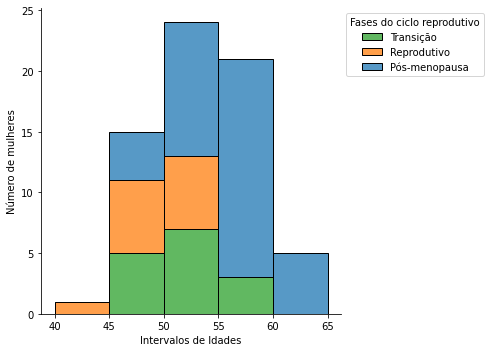

In [63]:
fpath = os.path.abspath(os.path.join(img_folder, f'hist-age-phase.{fmt}'))

ax = sns.displot(
    metadata_df, 
    x="idade", 
    hue="class_meno", 
    element="bars",  
    multiple="stack", 
    kind="hist",
    bins=6,
    binrange=[40,65],
    binwidth=5
    #kwargs={'binrange':[40,65], 'binwidth':5}
)
ax._legend.remove()
ax.set_axis_labels('Intervalos de Idades', 'Número de mulheres')
labels = ["Transição","Reprodutivo","Pós-menopausa"]
plt.legend(labels=labels, title="Fases do ciclo reprodutivo", loc=2, bbox_to_anchor=(1,1))
plt.savefig(fpath, format=fmt, dpi=dpi, bbox_inches='tight')
plt.show()

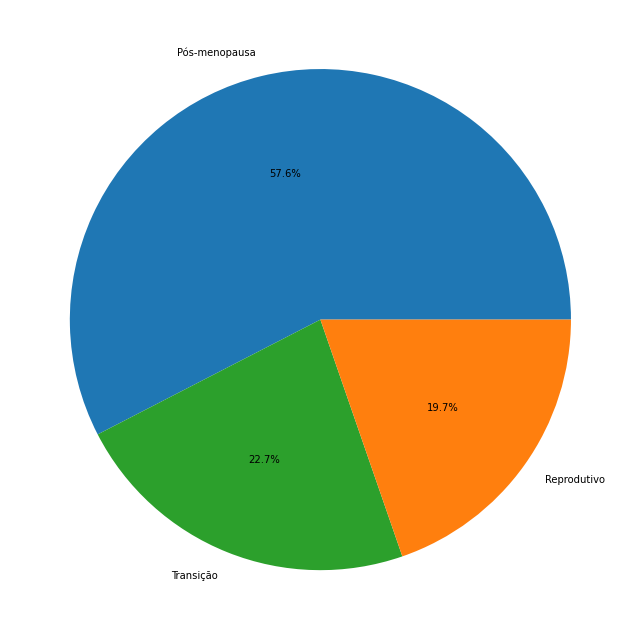

In [66]:
fpath = os.path.abspath(os.path.join(img_folder, f'pie-phases.{fmt}'))

labels = ['Pós-menopausa', 'Transição', 'Reprodutivo']
fig, ax = plt.subplots(figsize=(9, 9))
ax.pie(
    metadata_df['class_meno'].value_counts(),
    autopct='%.1f%%',
    labels=labels,
    colors=['tab:blue', 'tab:green', 'tab:orange']
)
plt.tight_layout()
plt.savefig(fpath, format=fmt, dpi=dpi, bbox_inches='tight')
plt.show()

Metadata visualization

In [4]:
# tabulate(sample_metadata).visualization

### Ingesting the ASV table

Load ASV table with filtered features. Extract absolute counts for each feature

In [5]:
frequency_table_path = tabs_file
frequency_table = Artifact.load(frequency_table_path)
frequency_table

<artifact: FeatureTable[Frequency] uuid: d5ba9a95-3a4d-4abb-80f8-899291b5be2d>

In [6]:
frequency_reps_path = reps_file
frequency_reps = Artifact.load(frequency_reps_path)
frequency_reps

<artifact: FeatureData[Sequence] uuid: 07f7b580-0043-4dc4-b429-38b4af4e4bd4>

Full ASV table visualization

In [7]:
#metadata.visualizers.tabulate(frequency_table.view(Metadata)).visualization

Transforming to Pandas DataFrame object

In [8]:
full_table_df = frequency_table.view(Metadata).to_dataframe().T
full_table_df

id,I1-M05,I10-M91,I11-M44,I12-M45,I13-M46,I14-M47,I15-M49,I16-M52,I17-M55,I18-M07,...,I68-M144,I69-M148,I7-M36,I70-M150,I71-M151,I72-M155,I73-M156,I75-M162,I76-M164,I8-M39
074b2d2eeb19288d75bf8e64784db602,0.0,786.0,0.0,1118.0,0.0,0.0,0.0,0.0,330.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1259.0,741.0,0.0,0.0,1263.0
6c3b33991621b6c3e04992794a55a3d9,0.0,1634.0,1228.0,1436.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1140.0,0.0,0.0,0.0,0.0,0.0,1427.0,0.0,0.0,773.0
8b7f2e8ca48676f3a47dfa784c8a9efe,0.0,540.0,0.0,872.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3095.0,0.0,0.0,0.0,0.0,0.0,0.0,652.0
7a1d4d3ec513655bbe964c4ab022e6fe,0.0,0.0,444.0,0.0,52.0,574.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,568.0,726.0,1033.0,315.0,0.0
b53b25874d0529b37d36bfc78e32c894,0.0,1464.0,1300.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1318.0,0.0,2022.0,621.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee5a1924a299e186d7f904e5aa898bd1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143582bcba9a90e4a585ed60042a6f0d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
c713157aa6936b23861463951dfb6a3b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
bd157fd42be3b6728d0080ee52836c14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Ingesting Taxon table

Ingesting table with all features and corresponding inferred taxon followed by a confidence score.

In [9]:
taxon_path = tax_file
table_tax = Artifact.load(taxon_path)
table_tax

<artifact: FeatureData[Taxonomy] uuid: 77490e83-8c5f-44d2-9360-5fcbe79fe7d5>

Taxon table visualization

In [10]:
# metadata.visualizers.tabulate(table_tax.view(Metadata)).visualization

Transforming to Pandas DataFrame object

In [11]:
table_tax_df = table_tax.view(Metadata).to_dataframe()

---

## Analyzing Taxononomy Table

### Expanding taxonomy Dataframe columns
Transforming Taxon column values to create seven new columns for each taxonomy level.

In [12]:
tax_levels = ['Reino', 'Filo', 'Classe', 'Ordem', 'Família', 'Gênero', 'Espécie']
table_tax_df[tax_levels] = table_tax_df['Taxon'].str.split(';', expand=True)
for t in tax_levels:
    table_tax_df[t] = table_tax_df[t].str.strip()

### Analyzing the ASV taxonomy

In [13]:
full_table_tax_df = pd.merge(full_table_df, table_tax_df, left_index=True, right_index=True)

In [14]:
full_unique_taxons = {l: list(filter(None, full_table_tax_df[l].unique())) for l in tax_levels}
print('--- Taxonomies found in the ASV table ---')
for k, v in full_unique_taxons.items():
    print(f'{k}: {len(v)}')

--- Taxonomies found in the ASV table ---
Reino: 3
Filo: 10
Classe: 14
Ordem: 30
Família: 53
Gênero: 137
Espécie: 96


### Analyzing *Swab vaginal* taxonomy

Generating the expanded Frequencies Dataframe with taxonomies.

In [15]:
full_table_tax_df

,I1-M05,I10-M91,I11-M44,I12-M45,I13-M46,I14-M47,I15-M49,I16-M52,I17-M55,I18-M07,...,I8-M39,Taxon,Confidence,Reino,Filo,Classe,Ordem,Família,Gênero,Espécie
074b2d2eeb19288d75bf8e64784db602,0.0,786.0,0.0,1118.0,0.0,0.0,0.0,0.0,330.0,0.0,...,1263.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9361387167487187,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
6c3b33991621b6c3e04992794a55a3d9,0.0,1634.0,1228.0,1436.0,0.0,0.0,0.0,0.0,0.0,0.0,...,773.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9069445037484893,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
8b7f2e8ca48676f3a47dfa784c8a9efe,0.0,540.0,0.0,872.0,0.0,0.0,0.0,0.0,0.0,0.0,...,652.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9999025048147963,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faecalibacterium,None
7a1d4d3ec513655bbe964c4ab022e6fe,0.0,0.0,444.0,0.0,52.0,574.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.7348376775850926,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_vulgatus
b53b25874d0529b37d36bfc78e32c894,0.0,1464.0,1300.0,1210.0,0.0,0.0,0.0,0.0,0.0,0.0,...,621.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9210205535092991,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee5a1924a299e186d7f904e5aa898bd1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Negativicutes; ...,0.9990948331078099,d__Bacteria,p__Firmicutes,c__Negativicutes,o__Veillonellales-Selenomonadales,f__Veillonellaceae,g__Dialister,None
143582bcba9a90e4a585ed60042a6f0d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.8940617497317686,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Ruminococcus,None
c713157aa6936b23861463951dfb6a3b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Bacilli; o__Ery...,0.9997641168791319,d__Bacteria,p__Firmicutes,c__Bacilli,o__Erysipelotrichales,f__Erysipelotrichaceae,g__Holdemanella,None
bd157fd42be3b6728d0080ee52836c14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9995510110548353,d__Bacteria,p__Firmicutes,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Lachnospiraceae_UCG-010,s__uncultured_organism


In [16]:
unique_taxons = {l: list(filter(None, table_tax_df[l].unique())) for l in tax_levels}
print('--- Taxonomies found in the ASV table ---')
for k, v in unique_taxons.items():
    print(f'{k}: {len(v)}')

--- Taxonomies found in the ASV table ---
Reino: 3
Filo: 10
Classe: 14
Ordem: 30
Família: 53
Gênero: 137
Espécie: 96


### Analyzing taxonomy confidence

In [17]:
table_tax_df['Confidence'].astype('float32').describe()

count    2918.000000
mean        0.942491
std         0.083970
min         0.413501
25%         0.909087
50%         0.989604
75%         0.999950
max         1.000000
Name: Confidence, dtype: float64

---

## Analyzing Samples

### Abundances

Viewing the total number of samples

In [18]:
print(f'Number of samples in the ASV: {len(full_table_df.columns)}')

Number of samples in the ASV: 66


#### Complete ASV

Samples with greater microbiological abundance in complete ASV.

In [19]:
full_table_df.sum().sort_values(ascending=False)[:10]

id
I52-M117    102690.0
I51-M116     86625.0
I24-M67      85448.0
I36-M93      82751.0
I10-M91      80208.0
I8-M39       78374.0
I11-M44      77125.0
I17-M55      76017.0
I55-M122     75836.0
I34-M88      74714.0
dtype: float64

Viewing basic sample statistics in complete ASV.

In [20]:
full_table_df.sum().describe()

count        66.000000
mean      41599.121212
std       24871.870661
min         590.000000
25%       21810.500000
50%       37042.500000
75%       63412.000000
max      102690.000000
dtype: float64

Plotting frequency distribution for all samples abundances in complete ASV.

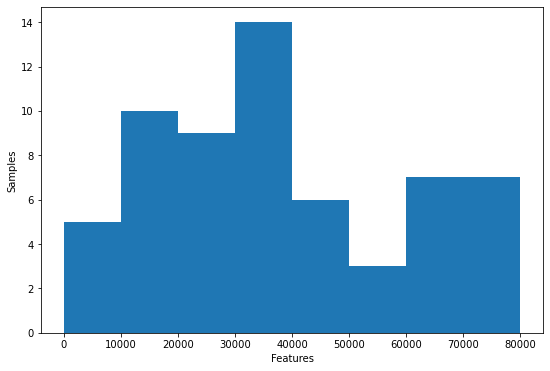

In [21]:
ax = full_table_df.sum().hist(bins=8, figsize=(9,6), range=(0, 80000))
ax.set_xlabel('Features')
ax.set_ylabel('Samples')
plt.grid(visible=None)
plt.savefig('samples-abundance-hist.pdf')
plt.show()

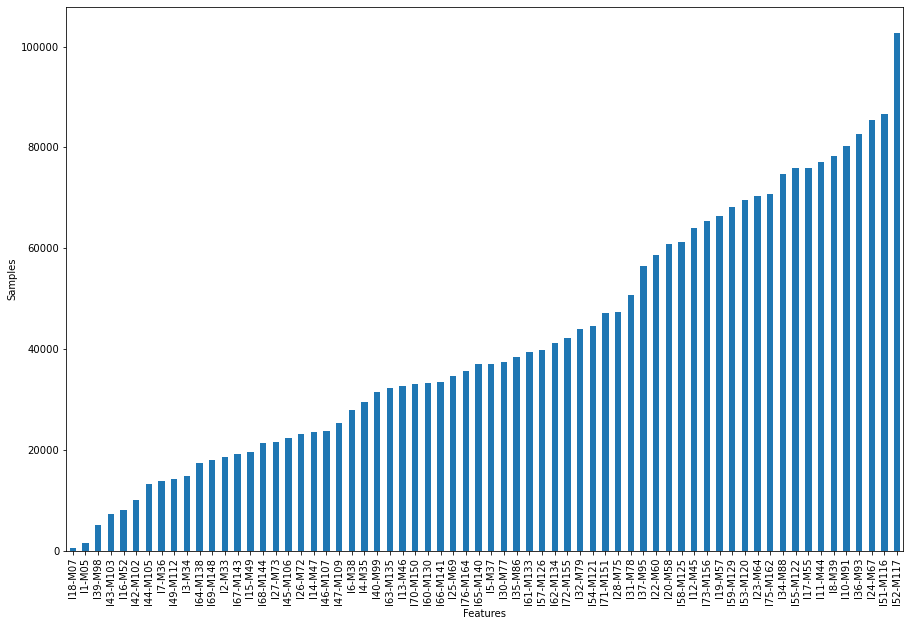

In [22]:
ax = full_table_df.sum().sort_values().plot(kind='bar', figsize=(15,10))
ax.set_xlabel('Features')
ax.set_ylabel('Samples')
# ax.set_xticklabels([])
plt.savefig('samples-abundance-bar.pdf')
plt.show()

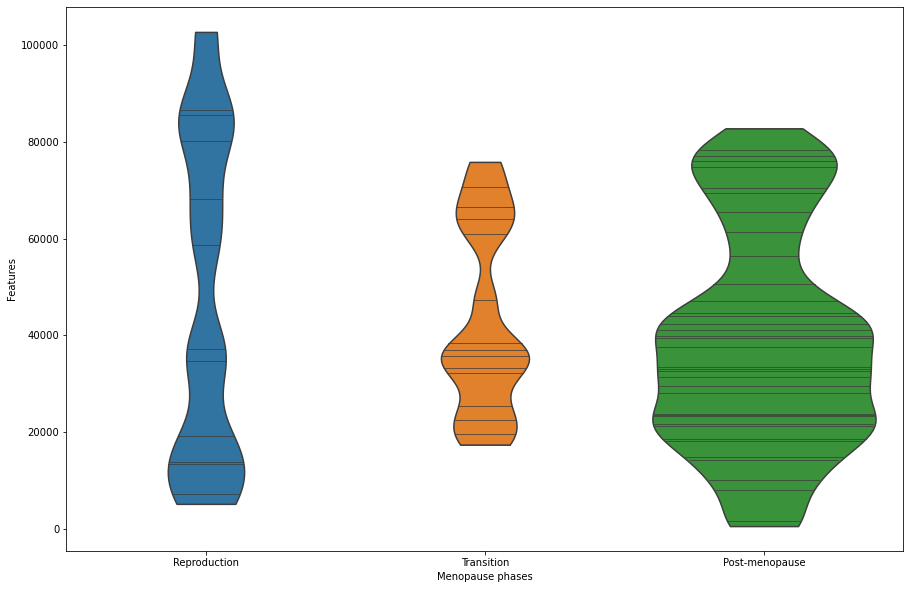

In [23]:
table_p0 = filter_samples(table=frequency_table, metadata=sample_metadata, where='[class_meno]="0"').filtered_table
table_p1 = filter_samples(table=frequency_table, metadata=sample_metadata, where='[class_meno]="1"').filtered_table
table_p2 = filter_samples(table=frequency_table, metadata=sample_metadata, where='[class_meno]="2"').filtered_table

table_p0_df = table_p0.view(Metadata).to_dataframe().T
table_p1_df = table_p1.view(Metadata).to_dataframe().T
table_p2_df = table_p2.view(Metadata).to_dataframe().T

tmp_df_p0 = pd.DataFrame(table_p0_df.sum(), columns=['sum'])
tmp_df_p1 = pd.DataFrame(table_p1_df.sum(), columns=['sum'])
tmp_df_p2 = pd.DataFrame(table_p2_df.sum(), columns=['sum'])

tmp_df_p0['class_meno'] = 'Reproduction'
tmp_df_p1['class_meno'] = 'Transition'
tmp_df_p2['class_meno'] = 'Post-menopause'

class_meno_df = pd.concat([tmp_df_p0, tmp_df_p1, tmp_df_p2])

plt.figure(figsize=(15,10))
ax = sns.violinplot(x='class_meno', y='sum', data=class_meno_df, scale='count', inner='stick', bw=.2, cut=0)
ax.set_ylabel('Features')
ax.set_xlabel('Menopause phases')
plt.savefig('vs-classmeno-features-violin.pdf')
plt.show()

In [24]:
features_ids_p0 = table_p0_df.index
features_ids_p1 = table_p1_df.index
features_ids_p2 = table_p2_df.index

### Diversities

Convert frequencies to binary values indicating presence or absence of a feature in a sample.

In [25]:
presence_absence_table = presence_absence(frequency_table).presence_absence_table
presence_absence_table_df = presence_absence_table.view(Metadata).to_dataframe().T

Top most abundant samples in the ASV.

In [26]:
presence_absence_table_df.sum().sort_values(ascending=False)[:10]

id
I51-M116    144.0
I8-M39      117.0
I24-M67     108.0
I17-M55     107.0
I11-M44     104.0
I10-M91     101.0
I36-M93      96.0
I23-M64      96.0
I52-M117     91.0
I75-M162     86.0
dtype: float64

Viewing basic sample statistics for the ASV.

In [27]:
presence_absence_table_df.sum().describe()

count     66.000000
mean      52.318182
std       30.393906
min        1.000000
25%       28.250000
50%       46.000000
75%       71.500000
max      144.000000
dtype: float64

Plotting frequency distribution for all the samples diversities.

<AxesSubplot:xlabel='id'>

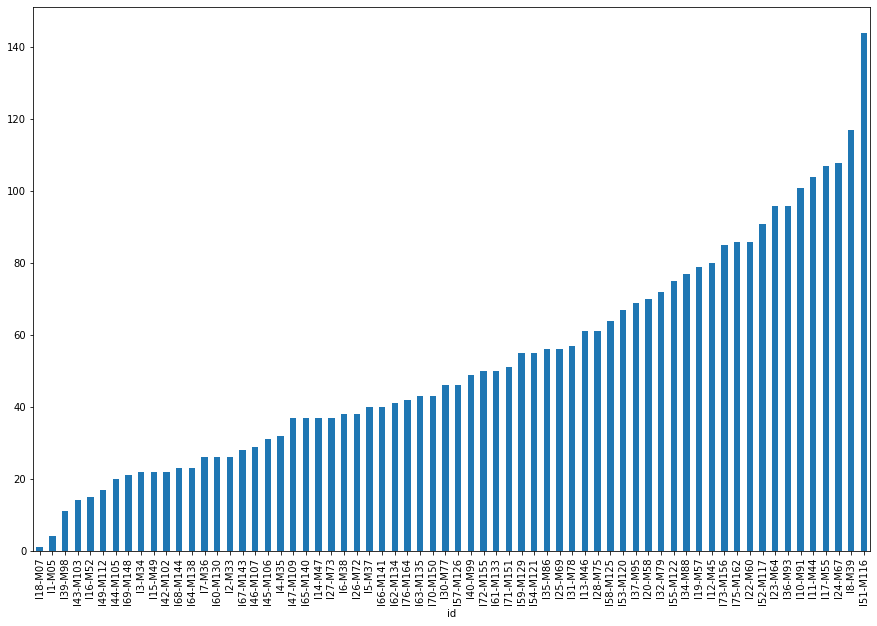

In [28]:
presence_absence_table_df.sum().sort_values().plot(kind='bar', figsize=(15,10))

---

## Analyzing Groups per samples types

In [29]:
features_df = full_table_df.sum(axis=1)

<AxesSubplot:>

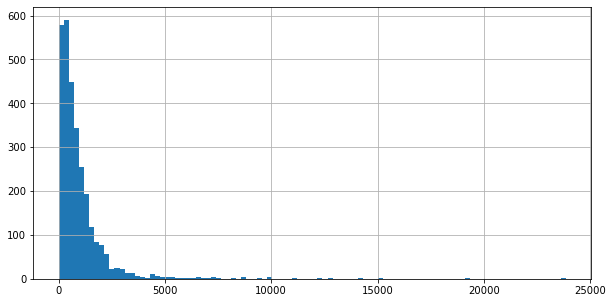

In [30]:
features_df.hist(bins=100, figsize=(10,5))

In [31]:
# Define pivot column for grouping function
sample_metadata.get_column('class_meno')
# Perform group by applying sum function
grouped_table = group(frequency_table, metadata=sample_metadata.get_column('class_meno'), axis='sample', mode='sum').grouped_table

Transforming to Pandas DataFrame object

In [32]:
grouped_table_df = grouped_table.view(Metadata).to_dataframe()
grouped_table_df

,074b2d2eeb19288d75bf8e64784db602,6c3b33991621b6c3e04992794a55a3d9,8b7f2e8ca48676f3a47dfa784c8a9efe,7a1d4d3ec513655bbe964c4ab022e6fe,b53b25874d0529b37d36bfc78e32c894,de1dfedd96859b1568df4edfc30dff9b,9182301e1a42f09bd5016aad44496c4a,3689595a73bd93c0301ac8956a15279e,53df627adf8340f26a37202ed7374f2e,a835129fb0fba121225f939f51049a86,...,440b18f112d726951157996929988d38,fa52840a8948f2b92eb37f273c919b00,890138d5a18e44b8337f1c60308d82a8,08c2a6ae87899aa52af5b1e4e706bca7,0c2c4652d0d65b835d97dddca0b3a102,ee5a1924a299e186d7f904e5aa898bd1,143582bcba9a90e4a585ed60042a6f0d,c713157aa6936b23861463951dfb6a3b,bd157fd42be3b6728d0080ee52836c14,7be16af1fd4a487fd9e6380727a69555
id,,,,,,,,,,,,,,,,,,,,,
2,8283.0,12499.0,8729.0,7407.0,8095.0,7234.0,6564.0,3589.0,4740.0,5207.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
0,8533.0,3018.0,3783.0,3200.0,1464.0,0.0,1958.0,1548.0,3901.0,954.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7042.0,3794.0,2615.0,3616.0,3232.0,5126.0,2612.0,4866.0,1310.0,3658.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [33]:
collapsed_table = collapse(grouped_table, taxonomy=table_tax, level=7).collapsed_table
collapsed_table

<artifact: FeatureTable[Frequency] uuid: c37b29c9-ef26-419f-b277-80f3d404a6ca>

In [34]:
# metadata.visualizers.tabulate(fezes_collapsed_table.view(Metadata)).visualization

In [35]:
collapsed_table_df = collapsed_table.view(Metadata).to_dataframe().T

#### View most abundant species for menopause class type: *reprodutivo*.

In [36]:
species_p0, counts_p0, full_tax = top_counts(collapsed_table_df, '0')
for i, c in enumerate(counts_p0):
    print(f'{i+1} - {full_tax[i]}: {c}')

1 - d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Catenibacterium;s__uncultured_bacterium: 12470
2 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002;s__uncultured_bacterium: 11793
3 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002;s__uncultured_organism: 9917
4 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__uncultured;s__gut_metagenome: 9869
5 - d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Dialister;s__uncultured_bacterium: 9062
6 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Ruminococcus;s__Ruminococcus_bicirculans: 7964
7 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Christensenellales;f__Christensenellaceae;g__Christensenellaceae_R-7_group;s__uncultured_prokaryote: 5322
8 - d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellal

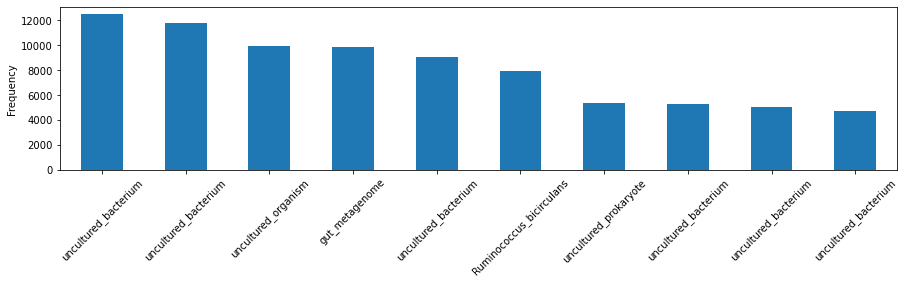

In [37]:
ax = pd.DataFrame(data=counts_p0, index=species_p0).plot(kind='bar', figsize=(15,3), rot=45)
ax.set_ylabel('Frequency')
ax.legend().set_visible(False)
plt.savefig('vs-classmeno-p0-top-tax.eps', bbox_inches = 'tight')
plt.show()

In [38]:
full_table_df.sum(axis=1).to_frame()

,0
074b2d2eeb19288d75bf8e64784db602,23858.0
6c3b33991621b6c3e04992794a55a3d9,19311.0
8b7f2e8ca48676f3a47dfa784c8a9efe,15127.0
7a1d4d3ec513655bbe964c4ab022e6fe,14223.0
b53b25874d0529b37d36bfc78e32c894,12791.0
...,...
ee5a1924a299e186d7f904e5aa898bd1,1.0
143582bcba9a90e4a585ed60042a6f0d,1.0
c713157aa6936b23861463951dfb6a3b,1.0
bd157fd42be3b6728d0080ee52836c14,1.0


In [39]:
freq_df = presence_absence_table_df.sum(axis=1).to_frame()
tax_freq_df = pd.merge(freq_df, table_tax_df, left_index=True, right_index=True)
tax_freq_df.rename(columns={0: 'Frequency'}, inplace=True)
tax_freq_df.sort_values(by=['Frequency'], ascending=False, inplace=True)
tmp_df = tax_freq_df.dropna(subset=['Espécie'])[:10]

#### View most abundant species for menopause class type: *Transição menopáusica/ pré menopausa*.

In [40]:
species_p1, counts_p1, full_tax = top_counts(collapsed_table_df, '1')
for i, c in enumerate(counts_p1):
    print(f'{i+1} - {full_tax[i]}: {c}')

1 - d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_stercoris: 10176
2 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002;s__uncultured_organism: 10117
3 - d__Bacteria;p__Desulfobacterota;c__Desulfovibrionia;o__Desulfovibrionales;f__Desulfovibrionaceae;g__Desulfovibrio;s__bacterium: 8294
4 - d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides;s__Parabacteroides_merdae: 6930
5 - d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_vulgatus: 6016
6 - d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Dialister;s__uncultured_bacterium: 5891
7 - d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__uncultured;s__metagenome: 5496
8 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__CAG-35

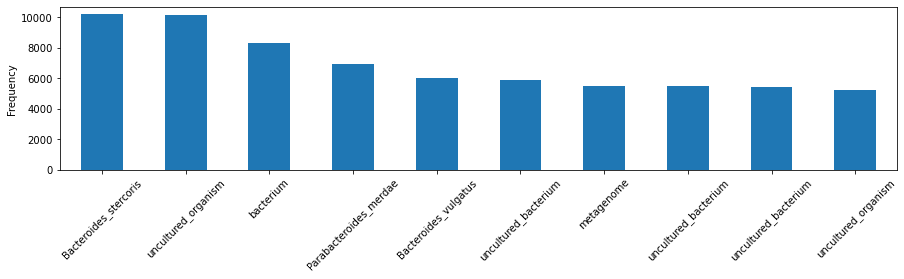

In [41]:
ax = pd.DataFrame(data=counts_p1, index=species_p1).plot(kind='bar', figsize=(15,3), rot=45)
ax.set_ylabel('Frequency')
ax.legend().set_visible(False)
plt.savefig('vs-classmeno-p1-top-tax.eps', bbox_inches = 'tight')
plt.show()

#### View most abundant species for menopause class type: *Pós-menopausa*.

In [42]:
species_p2, counts_p2, full_tax = top_counts(collapsed_table_df, '2')
for i, c in enumerate(counts_p2):
    print(f'{i+1} - {full_tax[i]}: {c}')

1 - d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Veillonellaceae;g__Dialister;s__uncultured_bacterium: 25510
2 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002;s__uncultured_bacterium: 24827
3 - d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides;s__Bacteroides_stercoris: 22903
4 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Oscillospiraceae;g__UCG-002;s__uncultured_organism: 22210
5 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;g__[Eubacterium]_ruminantium_group;s__uncultured_bacterium: 19932
6 - d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__CAG-352;s__uncultured_bacterium: 18065
7 - d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae;g__Catenibacterium;s__uncultured_bacterium: 16573
8 - d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f

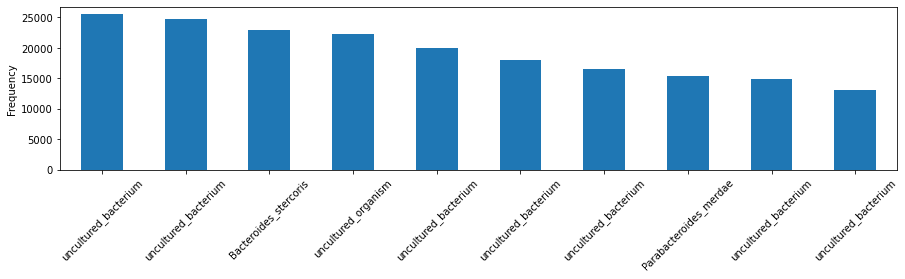

In [43]:
ax = pd.DataFrame(data=counts_p2, index=species_p2).plot(kind='bar', figsize=(15,3), rot=45)
ax.set_ylabel('Frequency')
ax.legend().set_visible(False)
plt.savefig('vs-classmeno-p2-top-tax.eps', bbox_inches = 'tight')
plt.show()

### Microorganisms frequences

In [44]:
freq_df = presence_absence_table_df.sum(axis=1).to_frame()
tax_freq_df = pd.merge(freq_df, table_tax_df, left_index=True, right_index=True)
tax_freq_df.rename(columns={0: 'Frequency'}, inplace=True)
tax_freq_df.sort_values(by=['Frequency'], ascending=False, inplace=True)
tax_freq_df.dropna()[:10]

,Frequency,Taxon,Confidence,Reino,Filo,Classe,Ordem,Família,Gênero,Espécie
7a1d4d3ec513655bbe964c4ab022e6fe,17.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.7348376775850926,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_vulgatus
84c637ccc4b3a7ddf249683f94a9e6b8,7.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.80958025129418,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_vulgatus
94d998377d1b0778de2a8369a12f7c61,7.0,d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...,0.7456998849690256,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides_vulgatus
8888e1f1a4f7c14ed50b43769cacf02f,6.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.7357499647767276,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Subdoligranulum,s__uncultured_bacterium
9182301e1a42f09bd5016aad44496c4a,6.0,d__Bacteria; p__Firmicutes; c__Negativicutes; ...,0.8566238192342637,d__Bacteria,p__Firmicutes,c__Negativicutes,o__Veillonellales-Selenomonadales,f__Veillonellaceae,g__Dialister,s__uncultured_bacterium
2b87c87096745aa778ddbb3eb16f9677,5.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.965235112857912,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__CAG-352,s__uncultured_bacterium
dc23795eaf76ec1afff097b7cc095fd7,5.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.7066510092291165,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Subdoligranulum,s__uncultured_bacterium
7e814b2213243a0ae956d9e03f2a641d,5.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.9634917919263422,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__CAG-352,s__uncultured_bacterium
f095498e0cc986c1f6229215f3793b07,5.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.8459164041922352,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Oscillospiraceae,g__UCG-002,s__uncultured_organism
6f355b0d3bd035382724f469e1f5e834,4.0,d__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.7302234911620858,d__Bacteria,p__Firmicutes,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Subdoligranulum,s__uncultured_bacterium


<AxesSubplot:ylabel='Frequency'>

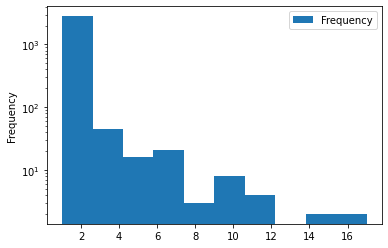

In [45]:
tax_freq_df.plot.hist(log=True)

ncultured_bacterium
ncultured_organism
ut_metagenome
arabacteroides_merdae
uman_gut
acteroides_stercoris
acteroides_vulgatus
etagenome
acterium
ncultured_prokaryote


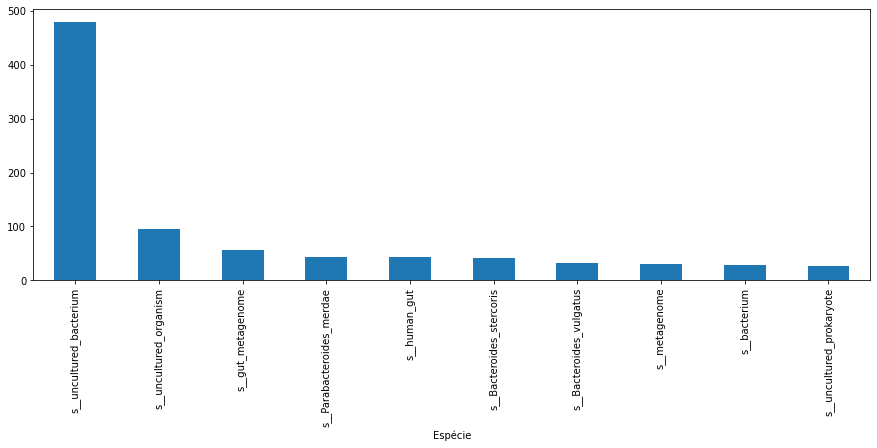

In [46]:
top = top_plot(tax_freq_df, 10, 'Espécie', 'Frequency')
for i in top.index:
    print(i[4:])
ax = top.plot(kind='bar', figsize=(15,5))
plt.savefig('vs-mostfreqs-top-tax_l7.eps')
plt.show()

ncultured_bacterium
ncultured_organism
ut_metagenome
acteroides_vulgatus
acteroides_stercoris
arabacteroides_merdae
uman_gut
acterium
ncultured_prokaryote
ncultured_rumen


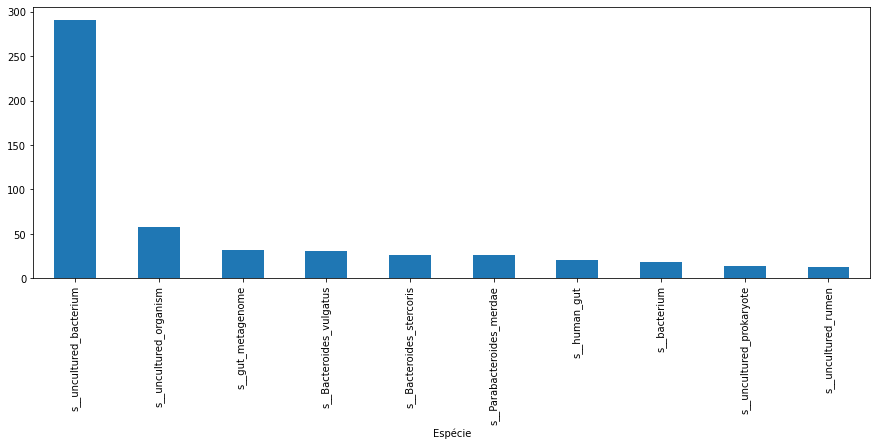

In [47]:
df = tax_freq_df.loc[features_ids_p2]
top = top_plot(df, 10, 'Espécie', 'Frequency')
for i in top.index:
    print(i[4:])
ax = top.plot(kind='bar', figsize=(15,5))
plt.savefig('vs-p2_mostfreqs-top-tax-l7.eps', bbox_inches='tight')
plt.show()

---